In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import pretty_midi

from tqdm import tqdm_notebook as tqdm
from collections import deque, Counter
from typing import Dict, List, Tuple

import seaborn
import scipy as sp

In [2]:
dataset = '../midi'
seq_len = 50
fs = 5

In [3]:
def midi_path_to_pianoroll(path: str, fs: int=5) -> np.ndarray:
    pmid = pretty_midi.PrettyMIDI(path)
    piano = pmid.instruments[0]
    pianoroll = piano.get_piano_roll(fs=fs)
    return pianoroll
    
def pianoroll_to_time_dict(pianoroll: np.ndarray) -> Dict[int, str]:
    times = np.unique(pianoroll.nonzero()[1])  # czasy gdzie występuje przynajmniej jedna nuta 
    index = pianoroll.nonzero()  # indeksy wszystkich nut
    dict_keys_time = {}

    for time in times:
        index_where = (index[1] == time).nonzero()  # pozycje nut, które występują w danym czasie, w indeksie
        notes = index[0][index_where]  # odszukanie nut
        dict_keys_time[time] = ','.join(notes.astype(str))
        
    return dict_keys_time


def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


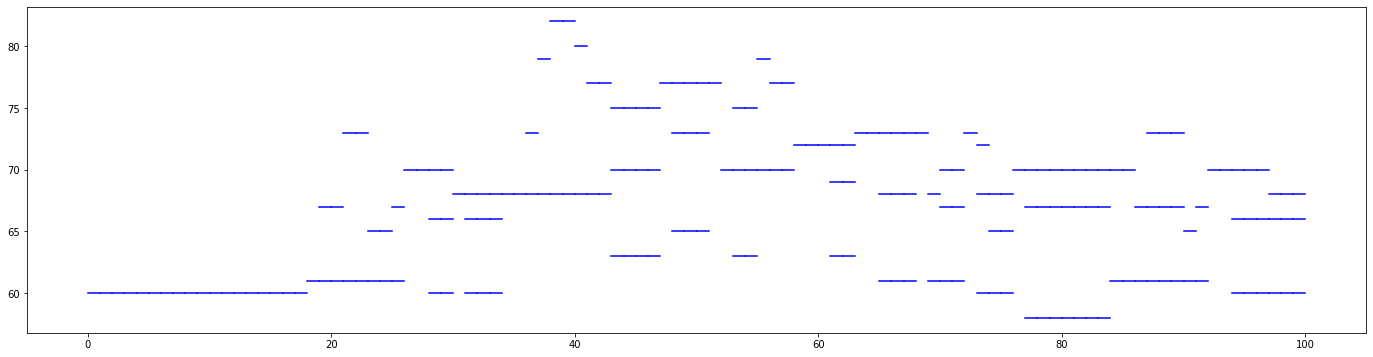

In [4]:
plt.figure(figsize=(24, 6))
original_pr = midi_path_to_pianoroll('../music/512.midi', fs=5)
for i in range(100):
    notes = np.nonzero(original_pr[:100, i])[0]
    
    for note in notes:
        plt.plot([i, i+1], [note, note], color='blue')
    

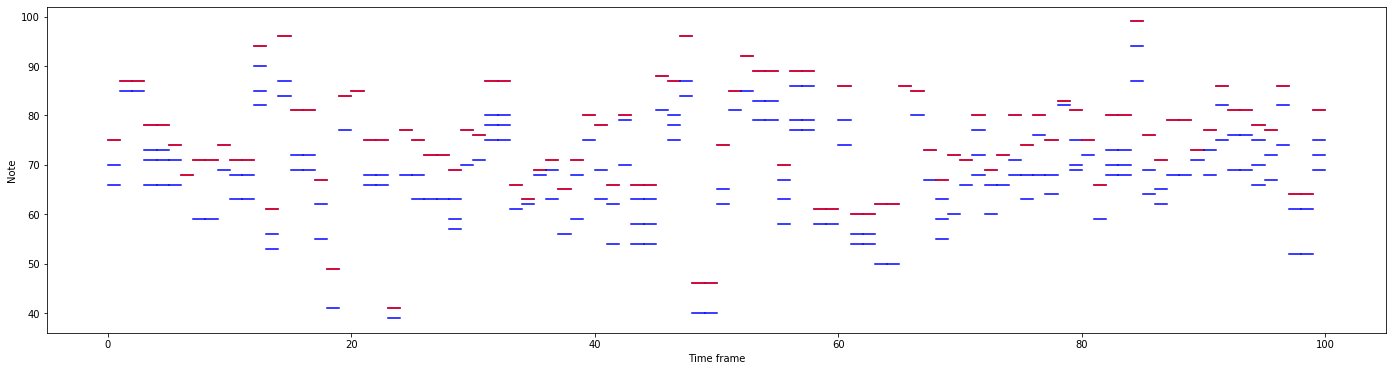

In [5]:
plt.figure(figsize=(24, 6))
original_pr = midi_path_to_pianoroll('../music/hello.midi', fs=5)
for i in range(100):
    notes = np.nonzero(original_pr[:100, i])[0]
    max_note = notes.max()
    for note in notes:
        plt.plot([i, i+1], [note, note], color='blue')
    plt.plot([i, i+1], [max_note, max_note], color = "red")
    plt.ylabel("Note")
    plt.xlabel("Time frame")

In [6]:
pr1 = midi_path_to_pianoroll('../music/256.midi', fs=5)
pr2 = midi_path_to_pianoroll('../music/512.midi', fs=5)

In [7]:
def calculate_rythm(piano_roll):
    notes = []
    values = []
    for i in range(piano_roll.shape[0]):
        if np.nonzero(piano_roll[i,:])[0].any():
            notes.append(np.nonzero(piano_roll[i,:])[0])
    for note in notes:
        val = 1
        for j in range(note.shape[0]-1):
            if note[j+1]!=note[j]+1:
                val = val+1
        values.append(val)
    notes_per_frame = sum(values)/piano_roll.shape[1]
    return notes_per_frame

In [12]:
calculate_rythm(pr1)

1.16

In [13]:
def calculate_cross_corr(*piano_rolls):
    melodies = []
    n_rows, n_cols = piano_rolls[0].shape
    for pr in piano_rolls:
        melodies.append(np.empty(n_cols))
    for i in range(n_cols):
        for it, melody in enumerate(melodies):
            melody[i] = np.nonzero(piano_rolls[it][:, i])[0].max()
    data = {"melody{}".format(i+1): melody for i, melody in enumerate(melodies)}
    melodies = pd.DataFrame(data)
    return melodies.corr()

In [14]:
calculate_cross_corr(pr1, pr2)

,melody1,melody2
melody1,1.00000,0.06535
melody2,0.06535,1.00000
